In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random
import time
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Adjust the options for viewing charts in notebook
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':100})

# Adjust options for viewing dataframes in notebook
pd.set_option('display.width', 2000)

# Set random seed to get the same result after each time running the code
tf.random.set_seed(1234)

# Define Functions

In [13]:
# Function for reading a data file
def read_data(name):
    df = pd.read_csv('./../../data/clean_data/' + name + '.csv')
    df['Hour'] = pd.to_datetime(df['Hour'])
    df = df.set_index('Hour')
    df.index.freq = 'h'
    return df

In [14]:
# Function for creating a LSTM model
def create_lstm(units, trainX):
    model = Sequential()
    model.add(tf.keras.Input(shape=(trainX.shape[1], trainX.shape[2])))     # Define shape
    model.add(LSTM (units = units, return_sequences = True))                # Input layer 
    model.add(LSTM(units = units))                                          # Hidden layer
    model.add(Dense(units = 1))                                             # Output layer
    model.compile(optimizer='adam', loss='mse')                             # Compile model
    return model

In [15]:
# Function for locating random batches from dataset

## Take dataset, length of training data, length of testing data and number of batches to extract as parameters
## Find a number of digits that represent the indices of the original dataset, where the extracted batches will start from
## Each subset dataset will not intersect with other datasets
def extract_batches(df, train_length, test_length, batch_count):
    start = time.time()
    random_int_list = []
    m = 0
    random.seed(1)
    data_end = len(df)
    new_data_size = train_length + test_length
    while m < batch_count:
        random_int = random.randint(0, data_end - new_data_size)
        q = 0
        for i in random_int_list:
            # Make sure batches do not overlap
            if i + new_data_size <= random_int or random_int + new_data_size <= i:
                pass
            else:
                q = 1
                # In case solution does not exist with current combination
                if time.time() - start > 2:
                    print('Restarted')
                    random_int_list = []
                    start = time.time()
                    m = 0

        # Prevent batches with 0 energy
        if df['Energy'][random_int: random_int + train_length].sum() == 0:
            q = 1

        # Record the position of the batch
        if q == 0:
            random_int_list.append(random_int)
            m = m + 1
    return random_int_list

In [16]:
# Function for creating datasets for machine learning
def create_dataset (input_data, look_back):
    features, values = [], []
    
    for i in range(len(input_data)-look_back):
        feature = input_data[i:i+look_back]
        features.append(feature)
        values.append(input_data[i+look_back])
        
    return np.array(features), np.array(values)

In [17]:
# Function for making predictions iteratively using self-feedback
def iterative_forecast(model, trainY, forecast_duration, look_back):
    forecast = []                           # Results
    look_back_data = trainY[-look_back:]    # Initial input
    train_mean = trainY[:,1].mean()         # Mean demand value
    train_max = trainY[:,1].max()           # Max. demand value

    # Predict iteratively
    i = 0
    while i < forecast_duration:
        prediction = model.predict(np.expand_dims(look_back_data, axis=0), verbose=0)

        # Round predictions below mean to zero
        if prediction[0][0] < train_mean:
            prediction[0][0] = 0
        # Cap predictions at max. demand value
        elif prediction[0][0] > train_max:
            prediction[0][0] = train_max
        
        look_back_minus_last = np.delete(look_back_data, 0, axis=0)             # Remove oldest input sample
        next_hour = np.array((look_back_minus_last[-1,0] + 1) % 24)             # Calculate next hour feature
        new_point = pd.DataFrame({'hour': next_hour, 'energy': prediction[0]})  # Combine next hour and predicted demand
        look_back_data = np.append(look_back_minus_last, new_point, axis=0)     # Add predicted values as input for next prediction
        forecast.append(prediction[0][0])                                       # Record result
        i = i + 1

    return forecast

In [18]:
# Function for analysing a model with given look_back and nodes_per_layer hyperparameters
def analyse(look_back, nodes_per_layer):
    df = read_data('HAMILTON')

    train_length = 336                  # 14 days
    test_length = 168                   # 7 days
    look_back = look_back               # How many past values are considered as features
    nodes_per_layer = nodes_per_layer   # How many nodes in each of the model's layers

    # Find appropriate, random, non-overlapping 5 batch locations
    start_index_list = extract_batches(df, train_length, test_length, 5)

    # Create the empty results dataframe to hold the results
    df_results = pd.DataFrame()
    row_headers = ['NRMSE', 'NMAE', 'Time (s)']

    # For each batch
    for start_index in start_index_list:
        # Record the training and testing dataset of the batch
        train = df[start_index: start_index + train_length]
        test = df[start_index + train_length: start_index + train_length + test_length]

        # Start the timer
        start = time.time()

        # Prepare data set for training and testing the model
        features = pd.DataFrame({'hour': train.index.hour, 'energy': train.Energy.values})
        trainX, trainY = create_dataset(np.array(features), look_back)
        testY = test.Energy

        # Create and train the LSTM model
        model_lstm = create_lstm(nodes_per_layer, trainX)
        model_lstm.fit(trainX, trainY, epochs=50, batch_size=16, verbose=0)

        # Make predictions
        predictions = iterative_forecast(model_lstm, trainY, test_length, look_back)
        
        # End the timer
        time_value = np.round(time.time() - start, 3)

        # Calculate Normalised Root Mean Square Error
        rmse = sqrt(mean_squared_error(testY, predictions))
        nrmse_value = np.round(rmse / np.mean(testY), 3)

        # Calculate Normalised Mean Absolute Error
        mae = mean_absolute_error(testY, predictions)
        nmae_value = np.round(mae / np.mean(testY), 3)

        # Append the batch results to the results dataframe
        row = [nrmse_value, nmae_value, time_value]
        df_results = pd.concat([df_results, pd.DataFrame([row], columns=row_headers)], ignore_index=True)

        # Plot
        predicted_values = pd.Series(predictions, index=testY.index)
        plot(train=train, predictions=predicted_values, actual=testY)

    # Calculate the average of each column
    average_value_list = np.round(df_results.mean(), 3).tolist()

    # Append the average to each column
    df_results = pd.concat([df_results, pd.DataFrame([average_value_list], columns=row_headers)], ignore_index=True)

    # Reformat the results dataframe
    df_results = df_results.transpose()
    df_results.columns = ['Batch 1', 'Batch 2', 'Batch 3', 'Batch 4', 'Batch 5', 'Average']

    # Display results
    display(df_results)

In [19]:
# Function for analysing a model with different look_back hyperparameters
def analyse_look_back(look_back_set, nodes_per_layer):
    df = read_data('HAMILTON')

    train_length = 336                          # 14 days
    test_length = 168                           # 7 days
    look_back_set = look_back_set               # How many past values are considered as features
    nodes_per_layer = nodes_per_layer           # How many nodes in each of the model's layers

    # Find appropriate, random, non-overlapping 5 batch locations
    start_index_list = extract_batches(df, train_length, test_length, 5)

    # Create the empty results dataframe to hold the results
    df_results = pd.DataFrame()
    row_headers = ['Look_back', 'NRMSE', 'NMAE', 'Time (s)']

    # For each batch
    for start_index in start_index_list:
        # Record the training and testing dataset of the batch
        train = df[start_index: start_index + train_length]
        test = df[start_index + train_length: start_index + train_length + test_length]

        for look_back in look_back_set:
            # Start the timer
            start = time.time()

            # Prepare data set for training and testing the model
            features = pd.DataFrame({'hour': train.index.hour, 'energy': train.Energy.values})
            trainX, trainY = create_dataset(np.array(features), look_back)
            testY = test.Energy

            # Create and train the LSTM model
            model_lstm = create_lstm(nodes_per_layer, trainX)
            model_lstm.fit(trainX, trainY, epochs=50, batch_size=16, verbose=0)

            # Make predictions
            predictions = iterative_forecast(model_lstm, trainY, test_length, look_back)
            
            # End the timer
            time_value = np.round(time.time() - start, 3)

            # Calculate Normalised Root Mean Square Error
            rmse = sqrt(mean_squared_error(testY, predictions))
            nrmse_value = np.round(rmse / np.mean(testY), 3)

            # Calculate Normalised Mean Absolute Error
            mae = mean_absolute_error(testY, predictions)
            nmae_value = np.round(mae / np.mean(testY), 3)

            # Append the batch results to the results dataframe
            row = [look_back, nrmse_value, nmae_value, time_value]
            df_results = pd.concat([df_results, pd.DataFrame([row], columns=row_headers)], ignore_index=True)

    return df_results

In [20]:
# Function for analysing a model with different nodes_per_layer hyperparameters
def analyse_nodes_per_layer(look_back, nodes_per_layer_set):
    df = read_data('HAMILTON')

    train_length = 336                          # 14 days
    test_length = 168                           # 7 days
    look_back = look_back                       # How many past values are considered as features
    nodes_per_layer_set = nodes_per_layer_set   # How many nodes in each of the model's layers

    # Find appropriate, random, non-overlapping 5 batch locations
    start_index_list = extract_batches(df, train_length, test_length, 5)

    # Create the empty results dataframe to hold the results
    df_results = pd.DataFrame()
    row_headers = ['Nodes_per_layer', 'NRMSE', 'NMAE', 'Time (s)']

    # For each batch
    for start_index in start_index_list:
        # Record the training and testing dataset of the batch
        train = df[start_index: start_index + train_length]
        test = df[start_index + train_length: start_index + train_length + test_length]

        for nodes_per_layer in nodes_per_layer_set:
            # Start the timer
            start = time.time()

            # Prepare data set for training and testing the model
            features = pd.DataFrame({'hour': train.index.hour, 'energy': train.Energy.values})
            trainX, trainY = create_dataset(np.array(features), look_back)
            testY = test.Energy

            # Create and train the LSTM model
            model_lstm = create_lstm(nodes_per_layer, trainX)
            model_lstm.fit(trainX, trainY, epochs=50, batch_size=16, verbose=0)

            # Make predictions
            predictions = iterative_forecast(model_lstm, trainY, test_length, look_back)
            
            # End the timer
            time_value = np.round(time.time() - start, 3)

            # Calculate Normalised Root Mean Square Error
            rmse = sqrt(mean_squared_error(testY, predictions))
            nrmse_value = np.round(rmse / np.mean(testY), 3)

            # Calculate Normalised Mean Absolute Error
            mae = mean_absolute_error(testY, predictions)
            nmae_value = np.round(mae / np.mean(testY), 3)

            # Append the batch results to the results dataframe
            row = [nodes_per_layer, nrmse_value, nmae_value, time_value]
            df_results = pd.concat([df_results, pd.DataFrame([row], columns=row_headers)], ignore_index=True)

    return df_results

In [21]:
# Function for plotting training, predicted, and actual values
def plot(train, predictions, actual):
    plt.plot(actual.index, actual.values, label='Actual', color='red')
    plt.plot(train.index, train.values, label='Train', color='orange')
    plt.plot(actual.index, predictions.values, label='Forecast', color='blue')
    
    plt.title('Forecast vs Actuals')
    plt.ylabel('Energy Consumption')
    plt.legend(loc='upper left', fontsize=8)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))

    plt.show()

In [22]:
# Plot results for different look_back hyperparameters
def plot_results_look_back(df_results, look_back_set):
    fig, axes = plt.subplots(3, 1)
    fig.patch.set_facecolor('xkcd:white')
    fig.set_size_inches(10, 6)
    fig.suptitle('LSTM Look_back Hyperparameter Exploration', fontsize=16)

    axes[0].plot(df_results['Look_back'], df_results['NRMSE'], color='orange', marker='o', linestyle='')
    axes[0].set_ylim([0, 4])
    axes[0].set_ylabel('NRMSE')
    axes[0].set_xticks(look_back_set)
    axes[0].set_title('NRMSE vs Look_back')
    axes[0].yaxis.grid(True, which='major', color='lightgrey', linestyle='-', linewidth=1)

    axes[1].plot(df_results['Look_back'], df_results['NMAE'], color='red', marker='o', linestyle='')
    axes[1].set_ylim([0, 4])
    axes[1].set_ylabel('NMAE')
    axes[1].set_xticks(look_back_set)
    axes[1].set_title('NMAE vs Look_back')
    axes[1].yaxis.grid(True, which='major', color='lightgrey', linestyle='-', linewidth=1)

    axes[2].plot(df_results['Look_back'], df_results['Time (s)'], color='blue', marker='o', linestyle='')
    axes[2].set_ylim([0, 200])
    axes[2].set_ylabel('Time (s)')
    axes[2].set_xlabel('Look_back')
    axes[2].set_xticks(look_back_set)
    axes[2].set_title('Execution Time vs Look_back')
    axes[2].yaxis.grid(True, which='major', color='lightgrey', linestyle='-', linewidth=1)

    plt.tight_layout()

    # Check if the target directory exists
    target_dir = '../../visualisations/hyperparameter_explorations'
    if not os.path.isdir(target_dir):
        os.makedirs(target_dir)

    # Save the plot
    plot_path = '../../visualisations/hyperparameter_explorations/LSTM_Look_back.png'
    plt.savefig(plot_path)
    plt.show()

In [23]:
# Plot results for different nodes_per_layer hyperparameters
def plot_results_nodes_per_layer(df_results, nodes_per_layer_set):
    fig, axes = plt.subplots(3, 1)
    fig.patch.set_facecolor('xkcd:white')
    fig.set_size_inches(10, 6)
    fig.suptitle('LSTM Nodes_per_layer Hyperparameter Exploration', fontsize=16)

    axes[0].plot(df_results['Nodes_per_layer'], df_results['NRMSE'], color='orange', marker='o', linestyle='')
    axes[0].set_ylim([0, 4])
    axes[0].set_ylabel('NRMSE')
    axes[0].set_xticks(nodes_per_layer_set)
    axes[0].set_title('NRMSE vs Nodes_per_layer')
    axes[0].yaxis.grid(True, which='major', color='lightgrey', linestyle='-', linewidth=1)

    axes[1].plot(df_results['Nodes_per_layer'], df_results['NMAE'], color='red', marker='o', linestyle='')
    axes[1].set_ylim([0, 4])
    axes[1].set_ylabel('NMAE')
    axes[1].set_xticks(nodes_per_layer_set)
    axes[1].set_title('NMAE vs Nodes_per_layer')
    axes[1].yaxis.grid(True, which='major', color='lightgrey', linestyle='-', linewidth=1)

    axes[2].plot(df_results['Nodes_per_layer'], df_results['Time (s)'], color='blue', marker='o', linestyle='')
    axes[2].set_ylim([0, 200])
    axes[2].set_ylabel('Time (s)')
    axes[2].set_xlabel('Nodes_per_layer')
    axes[2].set_xticks(nodes_per_layer_set)
    axes[2].set_title('Execution Time vs Nodes_per_layer')
    axes[2].yaxis.grid(True, which='major', color='lightgrey', linestyle='-', linewidth=1)

    plt.tight_layout()

    # Check if the target directory exists
    target_dir = '../../visualisations/hyperparameter_explorations'
    if not os.path.isdir(target_dir):
        os.makedirs(target_dir)

    # Save the plot
    plot_path = '../../visualisations/hyperparameter_explorations/LSTM_Nodes_per_layer.png'
    plt.savefig(plot_path)
    plt.show()

# Demonstrate the Forecasting Functionality

### With a set look_back of 48 hours and 64 nodes in input and hidden layers

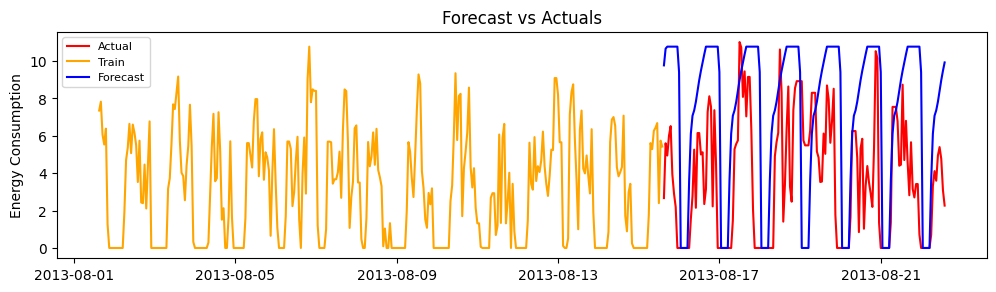

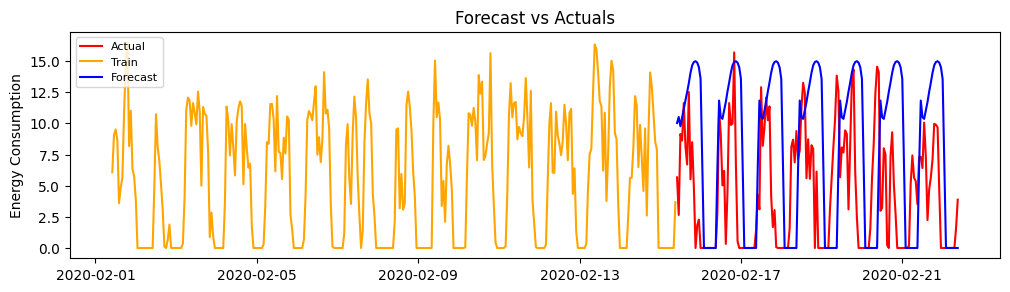

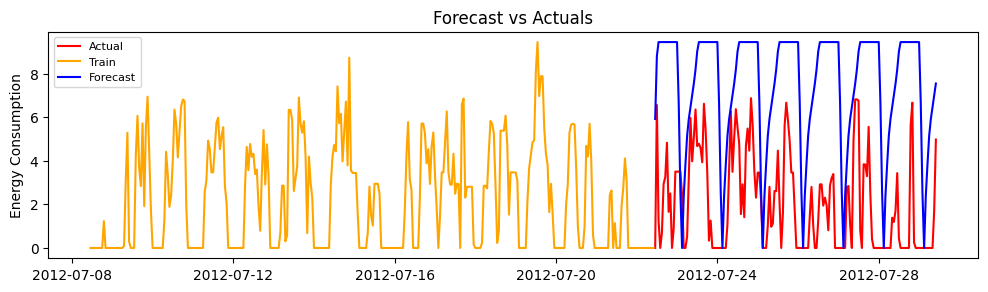

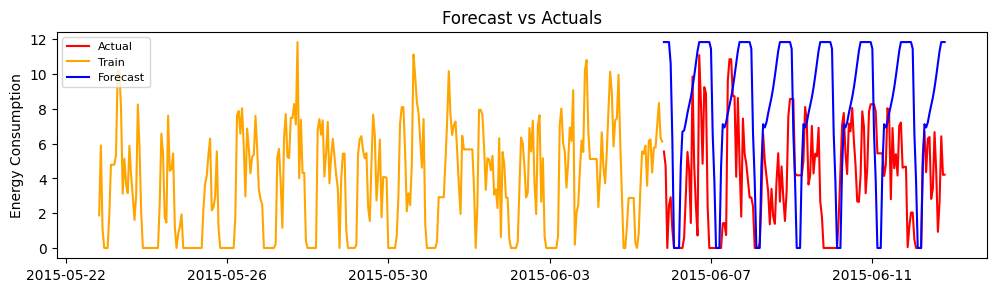

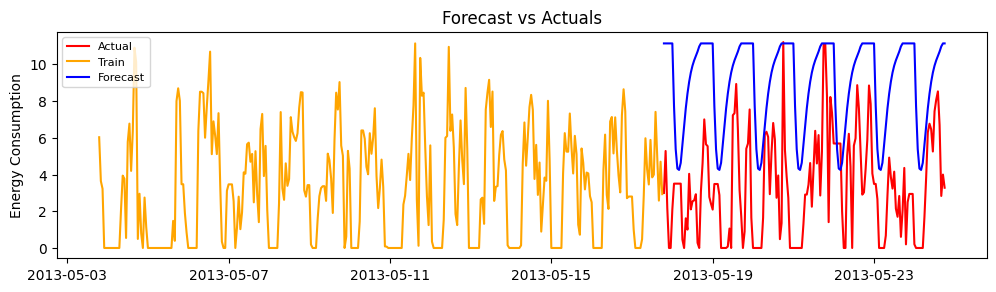

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Average
NRMSE,1.367,1.683,2.950,1.475,1.897,1.874
NMAE,1.061,1.270,2.626,1.210,1.692,1.572
Time (s),34.344,35.583,25.008,35.434,24.910,31.056


In [13]:
analyse(look_back=5, nodes_per_layer=64)

### Test different values of look_back to find the best-performing value (with 64 nodes per layer)

In [14]:
# Find best look_back
look_back_results = analyse_look_back(look_back_set=[6, 24, 48, 72, 168], nodes_per_layer=64)

# Display results
display(look_back_results)

,Look_back,NRMSE,NMAE,Time (s)
0,6,1.381,1.072,31.590
1,24,1.391,1.189,44.407
2,48,1.299,0.986,54.449
3,72,1.273,0.974,70.634
4,168,1.263,1.006,104.651
5,6,1.610,1.234,26.408
6,24,1.475,1.036,60.148
7,48,1.527,1.084,39.492
8,72,1.739,1.348,71.183
9,168,2.191,1.977,92.816


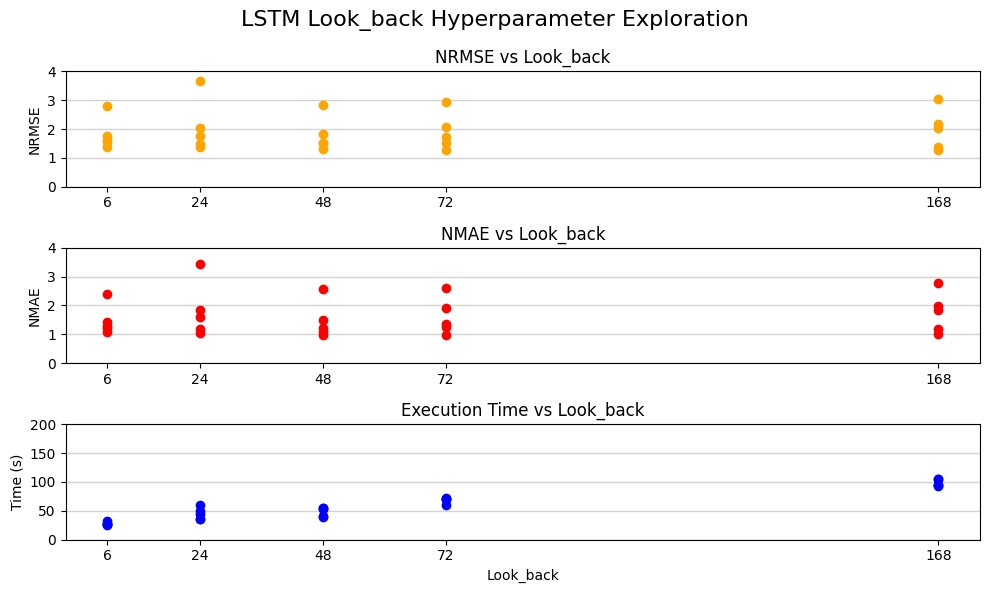

In [15]:
# Plot
plot_results_look_back(look_back_results, look_back_set=[6, 24, 48, 72, 168])

In [16]:
# Compare results
look_back_results.groupby('Look_back').mean().sort_values('NMAE')

,NRMSE,NMAE,Time (s)
Look_back,,,
48,1.7980,1.4724,48.4992
6,1.8208,1.4872,27.3342
72,1.9032,1.6106,68.6124
168,1.9808,1.7554,98.2584
24,2.0566,1.8220,45.1386


### Test different values of nodes_per_layer to find the best-performing value (with look_back = 48)

In [24]:
# Find best nodes_per_layer
nodes_per_layer_results = analyse_nodes_per_layer(look_back=48, nodes_per_layer_set=[16, 32, 64, 128])

# Display results
display(nodes_per_layer_results)

,Nodes_per_layer,NRMSE,NMAE,Time (s)
0,16,1.330,1.038,64.312
1,32,1.300,1.031,67.062
2,64,1.299,0.986,71.406
3,128,1.402,1.105,100.776
4,16,1.866,1.638,62.750
5,32,1.950,1.729,66.106
6,64,1.503,1.088,72.135
7,128,1.497,1.116,102.256
8,16,2.917,2.664,62.919
9,32,2.556,2.050,71.312


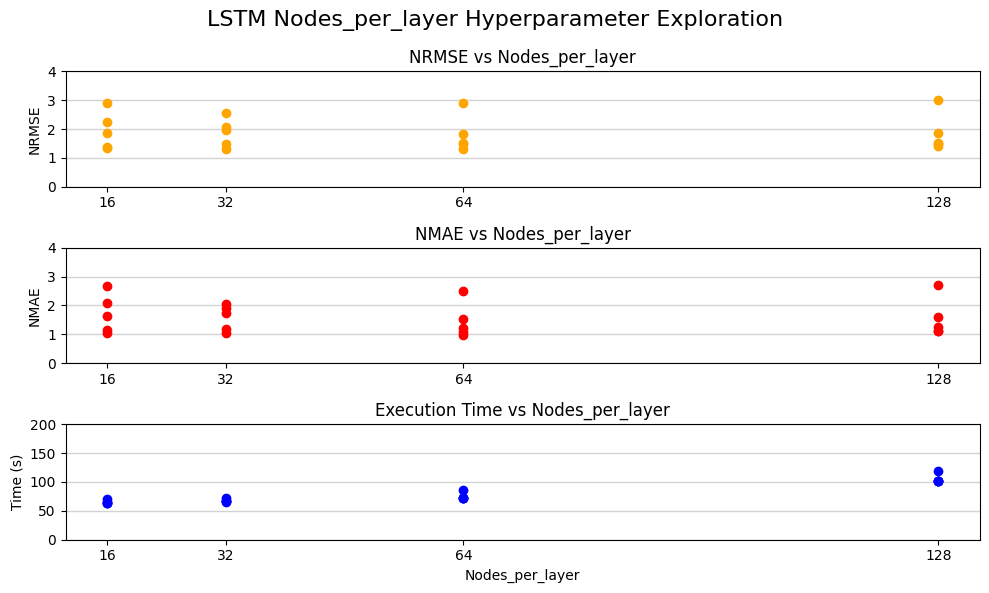

In [26]:
# Plot
plot_results_nodes_per_layer(nodes_per_layer_results, nodes_per_layer_set=[16, 32, 64, 128])

In [25]:
# Compare results
nodes_per_layer_results.groupby('Nodes_per_layer').mean().sort_values('NMAE')

,NRMSE,NMAE,Time (s)
Nodes_per_layer,,,
64,1.8056,1.4610,74.4898
128,1.8556,1.5596,105.2946
32,1.8732,1.5836,67.3078
16,1.9488,1.7150,64.8684


### The best hyperparameters for LSTM models seem to be look_back = 48 and nodes_per_layer = 64.